# Simulate differential accessibility

In [2]:
import src.data as data
import src.simulation as sim
import scanpy as sc
import episcanpy as epi
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import src.plots as myplt
import numpy as np
from pathlib import Path
import rpy2.robjects as ro
import scipy.stats as stats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load filtered data

In [3]:
file_path=Path('data/mouse_brain_5k/bin_by_cell_filtered.h5ad')

In [4]:
epidata = data.MouseBrainDataset()
adata = epidata.load_mtx(matrix_path=file_path)

## Simulate data

### Steps

1) Use simATAC to estimate the distribution parameters of a given dataset
2) Load differential accessibility (DA) configuration
3) Use DA config to modify the estimated distribution from 1)
    - New sets simulation parameters
4) Simulate new datasets using the different sets of estimated parameters
5) The resulting datasets should be differentially accessible based on the given DA config

In [5]:
def estimated_params(mouse_brain_adata) -> sim.Params:
    mouse_brain_adata = mouse_brain_adata[mouse_brain_adata.obs['cell_type'] == 'L5 IT']
    with sim.Simulator() as simulator:
        return simulator.estimate(mouse_brain_adata)

In [279]:
def simple_da_config() -> sim.DAConfig:
    cg_ids = ['CA', 'CB', 'CC']
    ncells = [50, 50, 50]
    lib_means = [21.3, 20, 20]
    cgs = {}
    for idx in range(len(cg_ids)):
        cgs[cg_ids[idx]] = sim.DACellGroup(id=cg_ids[idx], ncells=ncells[idx], lib_mean=lib_means[idx])

    proportions = [0.3, 0.2, 0.1]
    fg_ids = ['FA', 'FB', 'FC']
    fgs = {}
    for idx in range(len(fg_ids)):
        fgs[fg_ids[idx]] = sim.DAFeatureGroup(id=fg_ids[idx], proportion=proportions[idx])

    scores = np.array([0.2, 0.3, 0.0])
    for cg in cgs.values():
        accs = []
        for idx, fg in enumerate(fgs.values()):
            score = scores[idx]
            accs.append(sim.DAAccessibility(score=score, feature_group_id=fg.id))
        cg.accessibilities = accs
        scores = np.minimum(scores + 0.2, np.array([0.8] * len(scores)))

    return sim.DAConfig(cell_groups=cgs, feature_groups=fgs)

In [ ]:
adata = adata[adata.obs['cell_type'] == 'L5 IT']
# load DA config 
# todo read JSON file
cfg = simple_da_config()
# estimate params
params = estimated_params(adata)

In [281]:
for k, cg in cfg.cell_groups.items():
    print(f'{k}; lib_mean = {cg.lib_mean}')
    for acc in cg.accessibilities:
        print(acc)

CA; lib_mean = 21.3
DAAccessibility(feature_group_id='FA', score=0.2)
DAAccessibility(feature_group_id='FB', score=0.3)
DAAccessibility(feature_group_id='FC', score=0.0)
CB; lib_mean = 20
DAAccessibility(feature_group_id='FA', score=0.4)
DAAccessibility(feature_group_id='FB', score=0.5)
DAAccessibility(feature_group_id='FC', score=0.2)
CC; lib_mean = 20
DAAccessibility(feature_group_id='FA', score=0.6000000000000001)
DAAccessibility(feature_group_id='FB', score=0.7)
DAAccessibility(feature_group_id='FC', score=0.4)


In [282]:
adata_sim = sim.simulate_da(params=params, config=cfg)
adata_sim

AnnData object with n_obs × n_vars = 150 × 15032
    obs: 'Cell', 'LibSize', 'da_group'
    var: 'da_group'
    uns: 'simulation_params', 'da_config'

## Visualize DA

In [283]:
features = adata_sim.var_names[adata_sim.var['da_group'] == 'FA'][:100]

[Text(0.5, 1.0, 'CB')]

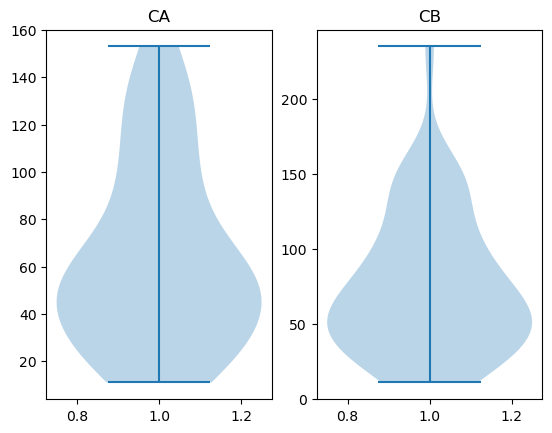

In [284]:
adata_feat = adata_sim[:, features[1]]
g1 = 'CA'
g2 = 'CB'
ca_arr = adata_feat[adata_feat.obs["da_group"] == g1].X.toarray()
cb_arr = adata_feat[adata_feat.obs["da_group"] == g2].X.toarray()

fig, ax = plt.subplots(1,2)
ax[0].violinplot(ca_arr)
ax[0].set(title=g1)
ax[1].violinplot(cb_arr)
ax[1].set(title=g2)

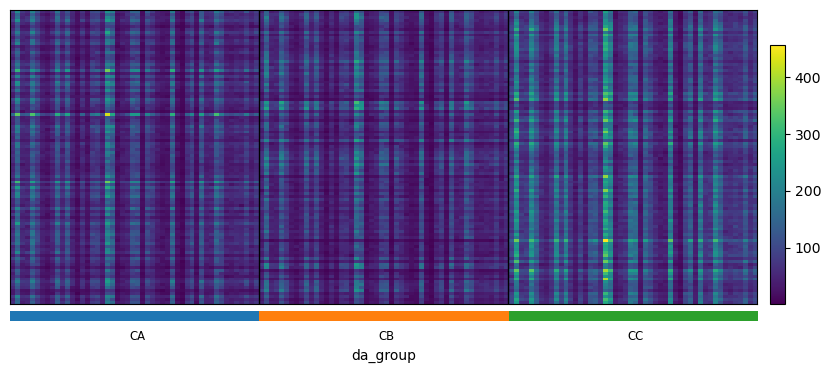

In [285]:
epi.pl.heatmap(adata_sim, groupby='da_group', var_names=features[:100], swap_axes=True)

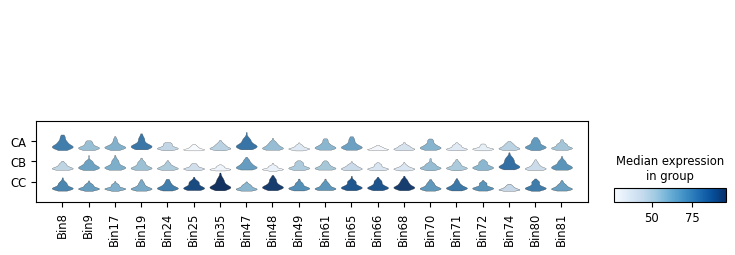

In [286]:
epi.pl.stacked_violin(adata_sim, groupby='da_group', var_names=features[:20], swap_axes=False)

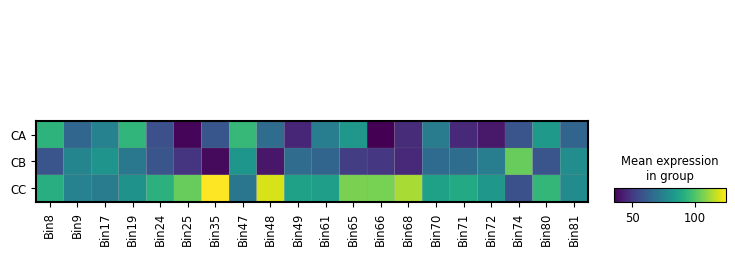

In [288]:
epi.pl.matrixplot(adata_sim, groupby='da_group', var_names=features[:20], swap_axes=False)

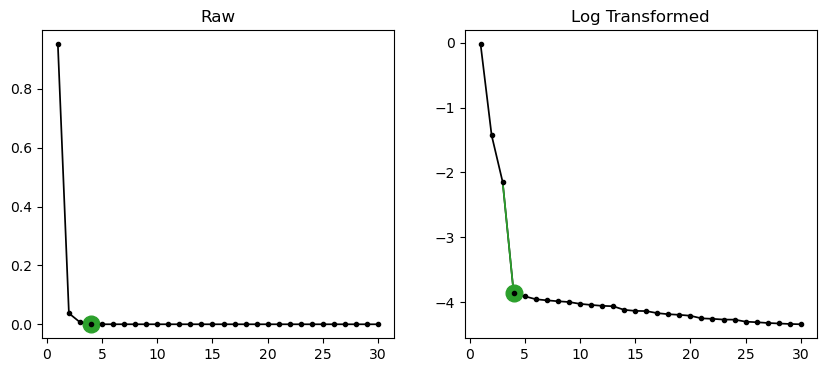

In [289]:
epi.pp.pca(adata_sim, n_comps=30)
n_comps = epi.pp.find_elbow(adata_sim, use_log=True, show_anno=False)

In [290]:
epi.pp.neighbors(adata_sim, n_pcs=n_comps, method="umap")

In [292]:
epi.tl.umap(adata_sim)

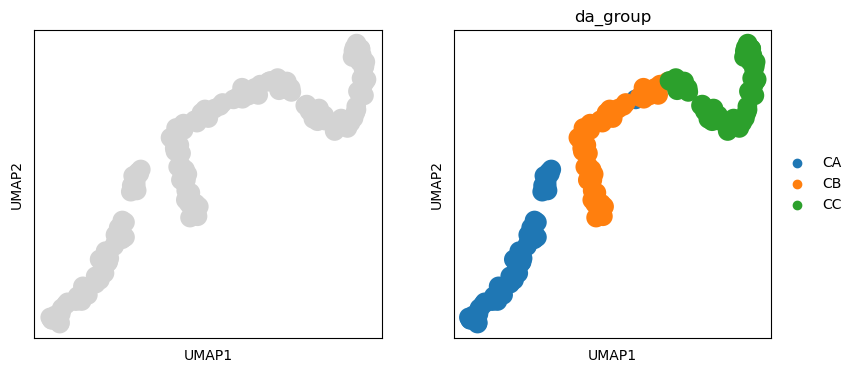

In [293]:
plt.rcParams["figure.figsize"]= (4, 4)
epi.pl.umap(adata_sim, color=[None, "da_group"])

In [297]:
epi.tl.rank_features(adata_sim, groupby='da_group', omic='ATAC', use_raw=False)

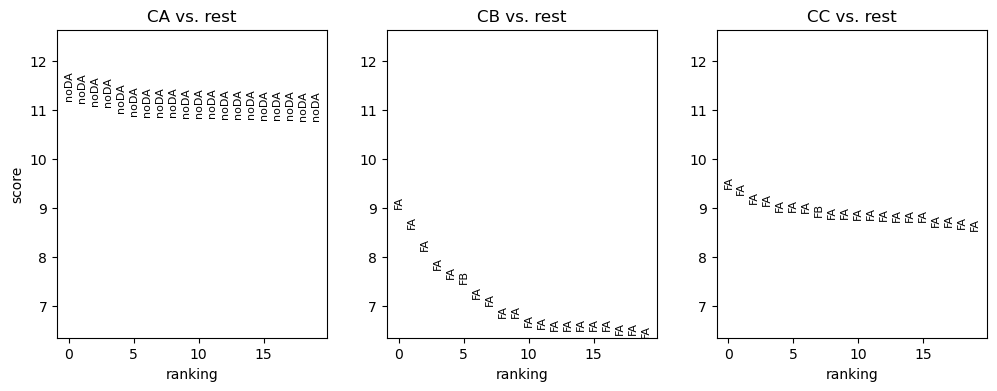

In [317]:
epi.pl.rank_feat_groups(adata_sim, feature_symbols='da_group')

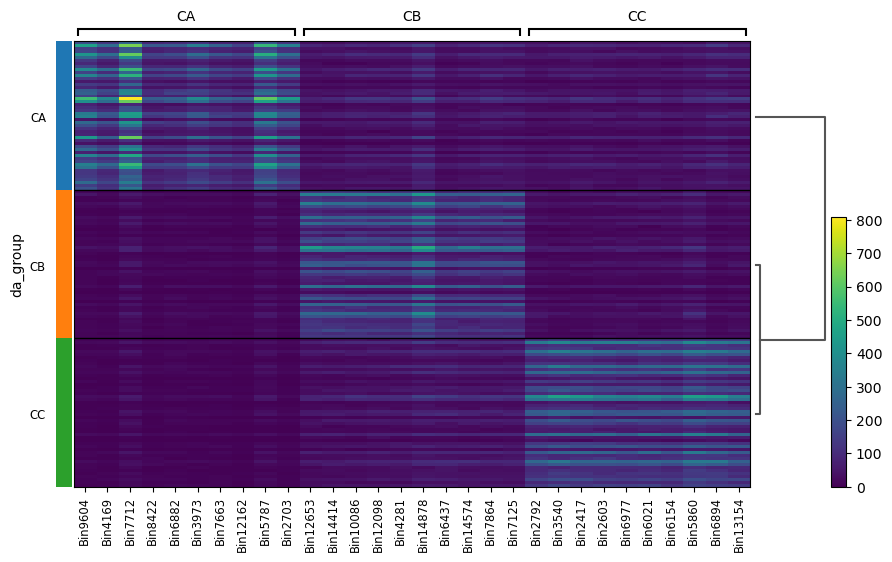

In [320]:
epi.pl.rank_feat_groups_heatmap(adata_sim)

### Next steps
DA
1) compute metrics for DA (treat it as a classification task)
2) simulate N times by changing the seed
3) Run different normalizations
4) Test for statistically different results

Clustering
1) simulate different cell types N times
2) Run different normalizations
3) compute silhouette scores
4) Test for statistically different results


+ Install simulator on the server to run simulations